<a href="https://colab.research.google.com/github/PDDA-OPDU/MICP-Analytics/blob/main/Gaussian_GenExtremeValues_CDF_PDF/GenExtremeValue_CDF_PDF_distributions.ipynb" 
    target="_parent"><img 
    src="https://colab.research.google.com/assets/colab-badge.svg" 
    alt="Open In Colab"/></a>

In [1]:
using_colab = True

In [2]:
if using_colab:


    !wget 'https://github.com/PDDA-OPDU/MICP-Analytics/raw/main/Gaussian_GenExtremeValues_CDF_PDF/CORE_DATA_AND_DESCRIPTIONS_DATABASE_HPMI.xlsx'
    #!wget 'https://github.com/Philliec459/Open-Source-Petrophysics/raw/main/photos.ZIP'

    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/STELLA_brief_ver2_backyard_grass_shoreline.ipynb
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_grass_shade_whiteshade.xlsx
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_FullSun.xlsx

    #!pip install altair
    #!pip install panel
    #!pip install pillow
    #!pip install jupyter_bokeh
    #!pip install altair_viewer
    #!pip install altair_transform
    !pip install scipy

    #!unzip photos


dyld[89455]: Library not loaded: /usr/local/opt/libunistring/lib/libunistring.2.dylib
  Referenced from: <6C399AFD-1783-33DE-B8D8-F154FD41D3AC> /usr/local/Cellar/wget/1.20.3_2/bin/wget
  Reason: tried: '/usr/local/opt/libunistring/lib/libunistring.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libunistring/lib/libunistring.2.dylib' (no such file), '/usr/local/opt/libunistring/lib/libunistring.2.dylib' (no such file), '/usr/local/lib/libunistring.2.dylib' (no such file), '/usr/lib/libunistring.2.dylib' (no such file, not in dyld cache), '/usr/local/Cellar/libunistring/1.2/lib/libunistring.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/Cellar/libunistring/1.2/lib/libunistring.2.dylib' (no such file), '/usr/local/Cellar/libunistring/1.2/lib/libunistring.2.dylib' (no such file), '/usr/local/lib/libunistring.2.dylib' (no such file), '/usr/lib/libunistring.2.dylib' (no such file, not in dyld cache)


# Load Phython libraries:

In [3]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import os

import seaborn as sns

from sklearn.metrics import r2_score

from scipy.stats import genextreme


# Load Data

## The following cells will load the Kansas Geologic Survey HPMI data from an Excel spreadsheet.


## 1) Load row of HPMI data starting at row A12:A130 for Pc and xxx12 to xxx130 for Sw

In [4]:
# Function to convert a number to an Excel-style column letter (supports beyond Z)
def get_column_letter(n):
    result = ""
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        result = chr(65 + remainder) + result
    return result

# Specify the file path and sheet number
file_path = 'CORE_DATA_AND_DESCRIPTIONS_DATABASE_HPMI.xlsx'
sheet_number = 0  # Second sheet, as pandas uses zero-indexing

# Read the Pc values (same for all samples)
pc_values = pd.read_excel(file_path, sheet_name=sheet_number, usecols="A", skiprows=11, nrows=119)

# Initialize a dictionary to store data for each sample
data_dict = {}

# Loop through each sample (from column B onward)
# Adjust the range according to the number of samples we need to process
for sample_num in range(1, 36):  # Example for 51 samples, adjust as necessary
    column_letter = get_column_letter(sample_num + 1)  # +1 because 'B' is column 2
    #print(f"Processing sample {sample_num} (Column {column_letter})")

    # Read Sw values for the current sample
    sw_values = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=11, nrows=119)
    
    # Read Porosity for the current sample (assumed to be in row 8)
    porosity = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=7, nrows=1).iloc[0, 0]
    
    # Read Permeability for the current sample (assumed to be in row 9)
    permeability = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=8, nrows=1).iloc[0, 0]

    # Read Num of Pore systems for the current sample (assumed to be in row 10)
    Num_pore_sys = pd.read_excel(file_path, sheet_name=sheet_number, usecols=column_letter, skiprows=9, nrows=1).iloc[0, 0]
    #print(Num_pore_sys)

    # Store the data in the dictionary
    data_dict[f'Sample_{sample_num}'] = {
        'Pc': pc_values.values.flatten(),
        'Sw': sw_values.values.flatten(),
        'Porosity (%)': porosity,
        'Permeability': permeability,
        'Num_pore_sys': Num_pore_sys,
    }

# Now, data_dict contains the data for all samples, structured for easy access
#print(data_dict)

# Batch 1, 2, or 3 from the spreadsheet
Pc_batch = 1


# Auto Generalized Extreme Value Distributions:

In [ ]:
# Loop through all samples
for Sample in data_dict.keys():
    sample_data = data_dict[Sample]

    porosity_sample = sample_data['Porosity (%)']
    perm_sample = sample_data['Permeability']
    Num_pore_sys = sample_data['Num_pore_sys']


    Pc = sample_data['Pc']
    Sw = sample_data['Sw']/100

    
    BVocc = ((100 - Sw) / 100) * porosity_sample
    #dbvocc = np.diff(BVocc)  # diff of BVocc for distribution, but lose one element in the array
    #dbvocc = np.insert(dbvocc, 0, 0)  # Our final dbvocc after adding a zero at the start
   

    dSw = np.diff(-1*Sw)
    dSw = 30*np.insert(dSw,0,0)

    
    def micp_to_gev(Pc, Sw, IFTheta, n):
        
        Rc = 2 * IFTheta * 0.147 / Pc
    
        
        ''' Initial guess '''
        x0 = np.array([0.2, 0.8, -2, -0.5, 0.05, 0.6])
    
        ''' Lower and upper bounds '''
        lb = np.array([0.002, 0.002, np.log10(Rc[-1]), np.log10(Rc[-1]), 0.01, 0.01])
        ub = np.array([1, 1, np.log10(Rc[0]), np.log10(Rc[0]), 5, 5])
    
        ''' Constraints '''
        Aeq = np.array([1] * n + [0] * 2 * n)
        Beq = np.array([1])
    
        ''' Objective function (using GEV CDF instead of normal CDF) '''
        def gev_cost_function(t):
            return gev_cost(np.log10(Rc), Sw, t, n)
    
        ''' Minimize the objective function with constraints '''
        cons = [{'type': 'eq', 'fun': lambda t: np.dot(Aeq, t) - Beq}]
        bounds = [(low, high) for low, high in zip(lb, ub)]
    
        res = minimize(gev_cost_function, x0, bounds=bounds, constraints=cons, method='SLSQP')
    
        x = res.x
        w = x[:n]
        u = x[n:2 * n]
        sig = x[2 * n:]
    
        ''' Sort u and adjust w and sigma accordingly '''
        sorted_indices = np.argsort(u)[::-1]
        u = u[sorted_indices]
        w = w[sorted_indices]
        sig = sig[sorted_indices]
    
        ''' Calculate Sw1 and PDF using GEV distribution '''
        Sw1 = np.zeros_like(Sw)
        pdf = np.zeros_like(Sw)
        for i in range(len(Pc)):
            Sw1[i] = np.sum(genextreme.cdf(np.log10(Rc[i]), 0.5, u, sig) * w)  # xi=0 for Gumbel (special case of GEV)
            pdf[i] = np.sum(genextreme.pdf(np.log10(Rc[i]), 0.5, u, sig) * w)


        ''' This does not work well'''
        # Calculate dSw (the derivative of Sw with respect to Rc)
        dPDF = np.diff(pdf) #/ np.diff(Rc)
        # Find the Rc value where dSw is maximum
        max_dPDF_index = np.argmax(dPDF)
        Rc_at_max_dPDF = Rc[max_dPDF_index]/2
        #print(f" Rc value where dSw is greatest: {round(Rc_at_max_dPDF,2)}")
        dPDF = 30*np.insert(dPDF,0,0)

    
        return w, u, sig, x, Sw1, pdf, Rc
    
    def gev_cost(X, c, t, n):
        w = t[:n]
        mu = t[n:2 * n]
        sigma = t[2 * n:]
    
        cm = np.zeros_like(c)
        for i in range(len(X)):
            cm[i] = np.sum(genextreme.cdf(X[i], 0.5 , mu, sigma) * w)  # xi=0 for Gumbel (special case of GEV)
    
        c = np.array(c)  # Ensure c is a numpy array
        
        # Element-wise comparison
        idx = np.where(c <= 1)[0]
        e   = np.linalg.norm(cm[idx] - c[idx])
    
        return e
    
    
    
    def plot_micp_results_gev(Pc, Sw, Sw1, Mode_xi):
    
        # Create the plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [2, 1]})
        
        # Plot Capillary Pressure vs. CDF
        ax1.plot(Sw, Pc, 'bo', label='HPMI Data')
        # Plot modeled Sw1 (Gaussian Fit) vs Pc
        ax1.plot(Sw1, Pc, 'r--', label='Modeled Sw1 (Gaussian CDF Fit)')
        ax1.set_yscale('log')
        ax1.set_xlabel('Cumulative GEV Distribution Function (CDF)')
        ax1.set_ylabel('Capillary Pressure (Psi)')
        ax1.set_title(f'Capillary Pressure Curve vs. GEV CDF {Sample}')
        ax1.grid(True, which="both", ls="--")
        ax1.legend()
    
        # Add the text below the plot
        text_string = (
                       f'Optimized parameters:  w1={round(w[0], 2)}, '
                       f'mu1={round(u[0], 2)},  mu2={round(u[1], 2)},  Mode_mu_xi={round(Mode_xi,2)},  '
                       f'sigma1={round(sig[0], 2)},  sigma2={round(sig[1], 2)},  xi=-0.5')
    
        # Adjust the position of the text as needed
        plt.figtext(0.5, -0.03, text_string, ha="center", fontsize=11, wrap=True)
    
    
        
        
        # Plot PDF with reversed axes
        #ax2.plot(dPDF, Rc, 'g-', label='dPDF')       
        ax2.plot(dSw, Rc, 'b-', label='HPMI PTD')
        ax2.plot(pdf, Rc, 'r--', label='Modeled PDF')
        ax2.plot(np.max(pdf), 10**Mode_xi, 'ro', label='Mode of PTD xi')
        
        ax2.set_xscale('linear')
        ax2.set_yscale('log')
        plt.gca().invert_yaxis()
        ax2.set_xlabel('PDF')
        ax2.set_ylabel('Pore Radius')
        ax2.set_title('GEV PDF vs. Pore Radius')
        ax2.grid(True, which="both", ls="--")
        ax2.legend()



    ''' Data Entry '''    
    # Example usage (replace Pc, Sw, IFTheta with real values):
    Pc = np.array(Pc)  # Replace with actual Pc values
    Sw = np.array(Sw)  # Replace with actual Sw values
    
    
    # IFTheta needs to be positive
    IFTheta = abs(480 * np.cos(np.radians(140)))  # Use the absolute value of IFTheta
    n = 2  # Number of Gaussian components
    
    
    # Run the model and plot results
    result = micp_to_gev(Pc, Sw, IFTheta, n)
    
    
    w, u, sig, x, Sw1, pdf, Rc = result


    '''https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution'''
    #Mode_xi   = u[0] + (sig[0]/0.5) *( 1 - 0.5)**(1/0.5)
    xi = -0.5
    Mode_xi = u[0] + sig[0] * (((1 + xi)**(-xi) - 1)/xi)
    #print(10**Mode_xi, 10**Mode_xi_2)

    
    #print(Mode_xi)
    
    plot_micp_results_gev(Pc, Sw, Sw1, Mode_xi)
    
    Swanson_raw = pdf/Pc
    Swanson_parameter = max(Swanson_raw)
    #print(Swanson_parameter)
    Perm_Swanson = 399 * Swanson_parameter**1.69
    

    # Optionally save the optimization results to an Excel file
    output_excel_file = 'Sample_Optimization_Results_Optimization_GEV_CDF_PDF.xlsx'

    '''if minimized_error > error_threshold:
        print("Bad result, optimization error is too high.")
    else:
        #print("Good result, acceptable optimization error.")'''

        
    data_to_save = {
        'Sample': Sample,
        'Porosity': porosity_sample,
        'Permeability': perm_sample,
        'Perm_Swanson': Perm_Swanson,       
        'w1': round(w[0], 3),
        'mu1': round(u[0], 2),
        'mu2': round(u[1], 2),
        'sigma1': round(sig[0], 2),
        'sigma2': round(sig[1], 2),
        'Xi': -0.5 ,        
        'Mode_xi': round(Mode_xi,2) ,        
        'Num_pore_sys': Num_pore_sys,
        
    }

   
    df = pd.DataFrame([data_to_save])

    # Check if the file already exists
    if os.path.exists(output_excel_file):
        with pd.ExcelWriter(output_excel_file, mode='a', if_sheet_exists='overlay', engine='openpyxl') as writer:
            df.to_excel(writer, index=False, header=False, startrow=writer.sheets['Sheet1'].max_row)
    else:
        df.to_excel(output_excel_file, index=False)



# Load Results from each sample run in the Automatic GEV Mode:

In [6]:
# Specify the file path and sheet number
file_path = 'Sample_Optimization_Results_Optimization_GEV_CDF_PDF.xlsx'

# Read the specific range from the sheet
df = pd.read_excel(file_path)

df.head()

,Sample,Porosity,Permeability,Perm_Swanson,w1,mu1,mu2,sigma1,sigma2,Xi,Mode_xi,Num_pore_sys
0,Sample_1,19.5,23.40,2.481886,0.749,0.26,-1.13,0.14,0.98,-0.5,0.34,1
1,Sample_2,14.5,41.40,14.176625,0.627,0.93,-0.88,0.27,1.16,-0.5,1.09,2
2,Sample_3,14.5,41.40,9.069595,0.710,0.78,-1.10,0.27,0.87,-0.5,0.94,2
3,Sample_4,13.9,6.88,3.682826,0.617,0.62,-1.32,0.31,0.96,-0.5,0.81,2
4,Sample_5,13.9,6.88,1.860305,0.709,0.39,-1.17,0.39,0.59,-0.5,0.62,2


In [7]:
# Assuming porosity and permeability data are stored in numpy arrays
porosity = df['Porosity']
permeability = df['Permeability']  # Replace with actual permeability data
df['lperm'] = np.log10(df['Permeability'])  # Replace with actual permeability data
lperm = df['lperm']
w1 = df['w1']  # Replace with actual permeability data
mu1 = df['mu1']  # Replace with actual permeability data
#df['lmu1'] = np.log10(df['mu1'])  # Replace with actual permeability data
#lmu1 = df['lmu1']
sigma1 = df['sigma1']  # Replace with actual permeability data
Mode_mu_xi = df['Mode_xi']
Perm_Swanson = df['Perm_Swanson']

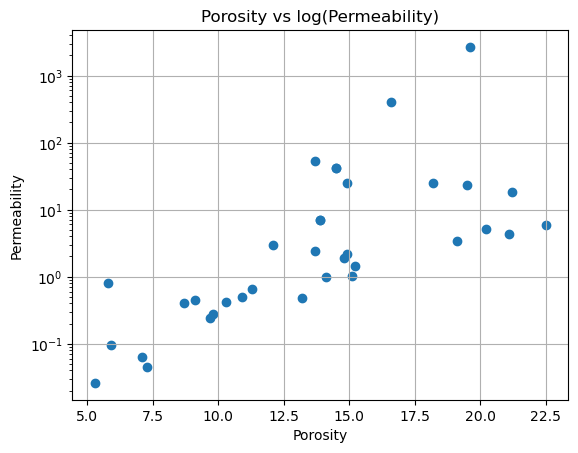

In [8]:
plt.scatter(porosity, permeability)
plt.xlabel('Porosity')
plt.ylabel('Permeability')
plt.title('Porosity vs log(Permeability)')
plt.yscale('log')
plt.grid()

plt.show()


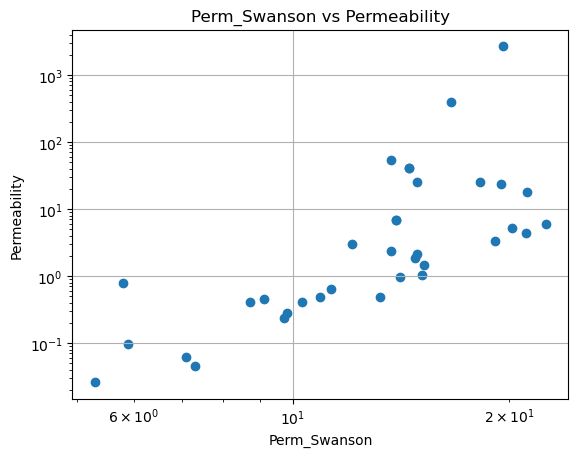

In [9]:
plt.scatter(porosity, permeability)
plt.xlabel('Perm_Swanson')
plt.ylabel('Permeability')
plt.title('Perm_Swanson vs Permeability')
plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.show()


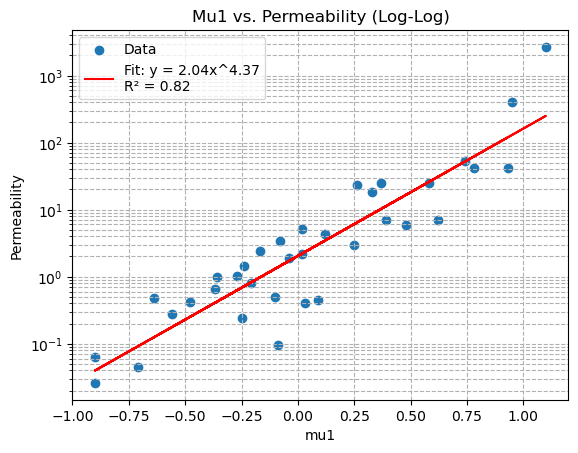

In [10]:
# Log-transform the data for linear regression
log_mu1 = mu1
log_perm = np.log(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_mu1, log_perm, 1)

# Calculate the predicted values in log scale
log_perm_pred = slope * log_mu1 + intercept

# Convert the predicted log-permeability back to the original scale
perm_pred = np.exp(log_perm_pred)

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_pred) ** 2)  # Residual sum of squares in log scale
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares in log scale
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale
plt.scatter(mu1, permeability, label='Data')

# Plot the regression line in the original scale
plt.plot(mu1, perm_pred, color='red', label=f'Fit: y = {np.exp(intercept):.2f}x^{slope:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('mu1')
plt.ylabel('Permeability')
plt.title('Mu1 vs. Permeability (Log-Log)')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()


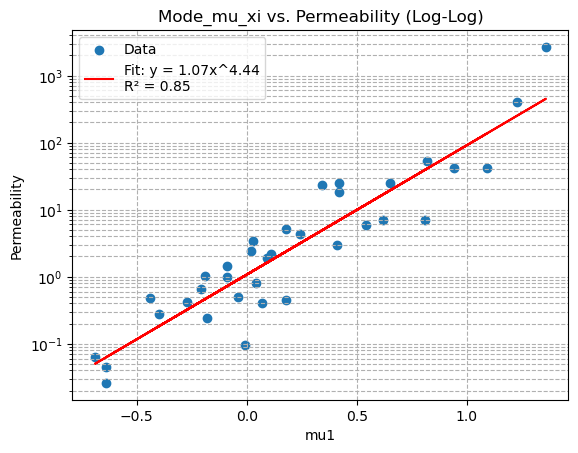

In [11]:
# Log-transform the data for linear regression
log_mu1 = Mode_mu_xi
log_perm = np.log(permeability)

# Perform linear regression on the log-transformed data
slope, intercept = np.polyfit(log_mu1, log_perm, 1)

# Calculate the predicted values in log scale
log_perm_pred = slope * log_mu1 + intercept

# Convert the predicted log-permeability back to the original scale
perm_pred = np.exp(log_perm_pred)

# Calculate R² for the log-log regression
ss_res = np.sum((log_perm - log_perm_pred) ** 2)  # Residual sum of squares in log scale
ss_tot = np.sum((log_perm - np.mean(log_perm)) ** 2)  # Total sum of squares in log scale
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot in log-log scale
plt.scatter(Mode_mu_xi, permeability, label='Data')

# Plot the regression line in the original scale
plt.plot(Mode_mu_xi, perm_pred, color='red', label=f'Fit: y = {np.exp(intercept):.2f}x^{slope:.2f}\nR² = {r2:.2f}')

# Add labels, title, and grid
plt.xlabel('mu1')
plt.ylabel('Permeability')
plt.title('Mode_mu_xi vs. Permeability (Log-Log)')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which='both', ls='--')

# Add legend for the regression equation and R²
plt.legend()

# Show the plot
plt.show()


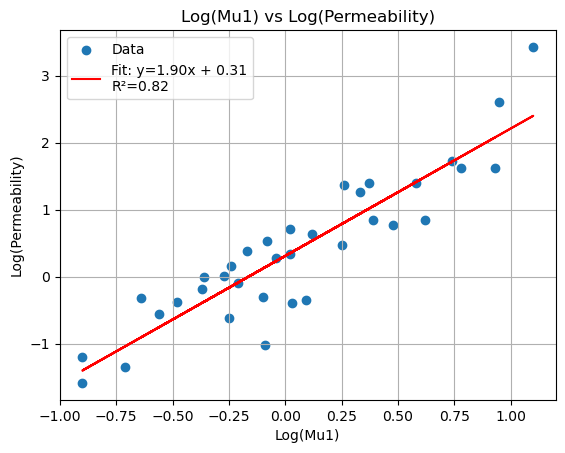

In [12]:
# Assuming lmu1 and lperm are the log-transformed data arrays for mu1 and permeability

# Perform linear regression using numpy.polyfit
slope, intercept = np.polyfit(mu1, lperm, 1)

# Calculate the predicted values for lperm
lperm_pred = slope * mu1 + intercept

# Calculate R² correctly
ss_res = np.sum((lperm - lperm_pred) ** 2)  # Residual sum of squares
ss_tot = np.sum((lperm - np.mean(lperm)) ** 2)  # Total sum of squares
r2 = 1 - (ss_res / ss_tot)

# Plot the scatter plot and the regression line
plt.scatter(mu1, lperm, label='Data')

# Plot the regression line (on the log-log scale)
plt.plot(mu1, lperm_pred, color='red', label=f'Fit: y={slope:.2f}x + {intercept:.2f}\nR²={r2:.2f}')

# Add labels, title, and grid
plt.xlabel('Log(Mu1)')
plt.ylabel('Log(Permeability)')
plt.title('Log(Mu1) vs Log(Permeability)')

plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.show()


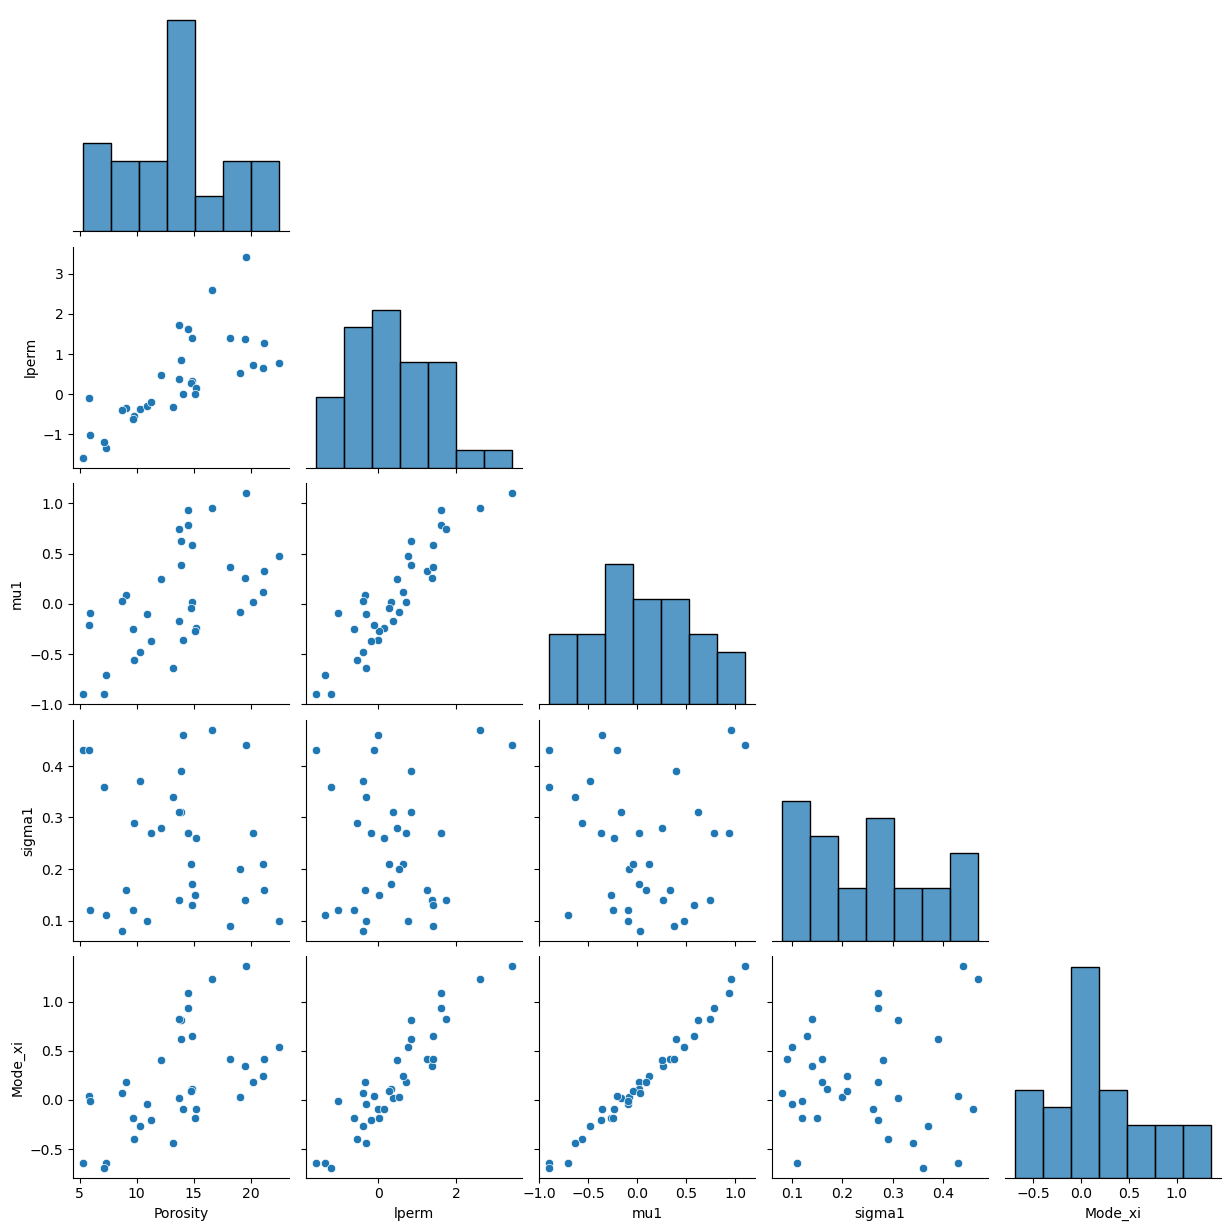

In [13]:
import seaborn as sns


# Create a new DataFrame with the columns of interest
data_to_plot = df[['Porosity', 'lperm',  'mu1', 'sigma1', 'Mode_xi']]

# Create a pairplot of all the selected data
sns.pairplot(data_to_plot, corner=True)

# Show the plot
